<a href="https://colab.research.google.com/github/dbamman/nlp23/blob/master/AP/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT for binary or multiclass document classification using the [CLS] token as the document representation; trains a model (on `train.txt`), uses `dev.txt` for early stopping, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

Before executing this notebook on Colab, make sure you're running on cuda (`Runtime > Change runtime type > GPU`) to make use of GPU speedups.

In [123]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [170]:
from transformers import BertModel, BertTokenizer
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.stats import norm
import math
import pandas as pd

In [125]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:


# Change this to the directory with your data
directory="/content/drive/MyDrive/ap_data/"

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [128]:
def read_labels(filename):
    labels={}
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            # print(cols[2][5])
            label = cols[2]
            if label not in labels:
                labels[label]=len(labels)
    return labels

In [129]:
def read_data(filename, labels, max_data_points=1000):
  
    data = []
    data_labels = []
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2]
            text = cols[3]
            
            data.append(text)
            data_labels.append(labels[label])
            

    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)
    
    if max_data_points is None:
        return data, data_labels
    
    return data[:max_data_points], data_labels[:max_data_points]

In [130]:
labels=read_labels("%s/train.tsv" % directory)

In [131]:
train_x, train_y=read_data("%s/train.tsv" % directory, labels, max_data_points=None)

In [132]:
dev_x, dev_y=read_data("%s/dev.tsv" % directory, labels, max_data_points=None)

In [133]:
test_x, test_y=read_data("%s/test.tsv" % directory, labels, max_data_points=None)

In [134]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1                          
    return corr/total, total

In [135]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()
    
        self.model_name=bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = BertModel.from_pretrained(self.model_name)
        
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=16, max_toks=510):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.
      
        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

In [136]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [137]:
def train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    bert_model.to(device)

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=30
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        bert_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _=evaluate(bert_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(bert_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model


In [138]:
# small BERT -- can run on laptop
# bert_model_name="google/bert_uncased_L-2_H-128_A-2"
# model_filename="mybert.model"
# embedding_size=128
# doLowerCase=True

# bert-base -- slow on laptop; better on Colab
bert_model_name="bert-base-cased"
model_filename="mybert.model"
embedding_size=768
doLowerCase=False

torch.backends.cuda.max_split_size_mb = 86

torch.cuda.empty_cache()
model=train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, dev accuracy: 0.857
Epoch 1, dev accuracy: 0.857
Epoch 2, dev accuracy: 0.905
Epoch 3, dev accuracy: 0.914
Epoch 4, dev accuracy: 0.933
Epoch 5, dev accuracy: 0.933
Epoch 6, dev accuracy: 0.914
Epoch 7, dev accuracy: 0.924
Epoch 8, dev accuracy: 0.914
Epoch 9, dev accuracy: 0.933
Epoch 10, dev accuracy: 0.924
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.933


In [139]:
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.962, 95% CIs: [0.926 0.999]



#Preciction Code --> using forward method below:

In [215]:
# print(test_batch_x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
model_filename="mybert.model"
model.load_state_dict(torch.load(model_filename))
model = model.to(device)


model.eval()

test_batch_x, test_batch_y = model.get_batches(test_x, test_y)


# with torch.no_grad():
#     inputs = test_batch_x
#     print(inputs)
#     outputs = model.forward(inputs)
#     predictions = torch.argmax(outputs, dim=1)

x, y = test_batch_x, test_batch_y

predictions = []

with torch.no_grad():
    for batch_x, batch_y in zip(x, y):
        batch_x = {k: v.to(device) for k, v in batch_x.items()}
        batch_y = batch_y.to(device)
        
        y_preds = model.forward(batch_x)
        for idx, y_pred in enumerate(y_preds):
            prediction = torch.argmax(y_pred)
            predictions.append(prediction.item())


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [216]:
for i, pred in enumerate(predictions):
  if pred == 1:
    predictions[i] = 0
  elif pred == 2: 
    predictions[i] = 1


In [217]:
# predictions

In [218]:
df = pd.read_csv("%s/test.tsv" % directory,  delimiter='\t')
df

,data point ID (a unique identifier),adjudicated,label,the original text (not tokenized)
0,<14561475.1075851769621.JavaMail.evans@thyme>,adjudicated,1,"California=01,s power crisis has generated hea..."
1,<18898317.1075840081875.JavaMail.evans@thyme>,adjudicated,0,"March 28, 1999 This is the first day of the K..."
2,<17692323.1075842833664.JavaMail.evans@thyme>,adjudicated,0,Enron is forming a new organization - - the En...
3,<9122820.1075845525014.JavaMail.evans@thyme>,adjudicated,0,"David, just heard that you joined the 2001 Enr..."
4,<22939192.1075840081765.JavaMail.evans@thyme>,adjudicated,0,Great to hear from you! I got both messages. ...
5,<33296131.1075849842083.JavaMail.evans@thyme>,adjudicated,0,"We've done it again, everyone. Enron has bee..."
6,<32077243.1075845503525.JavaMail.evans@thyme>,adjudicated,1,"Jeffrey, Congratulations on the Business Week..."
7,<22213691.1075840081848.JavaMail.evans@thyme>,adjudicated,0,"Mom and Dad, Got mom's letter last week; and ..."
8,<10710305.1075851723376.JavaMail.evans@thyme>,adjudicated,0,"We've done it again, everyone. Enron has bee..."
9,<15805298.1075840065866.JavaMail.evans@thyme>,adjudicated,0,I'm in one piece; oblivious (if not for the ne...


In [219]:
df['BERT_Preds'] = pd.Series(predictions)


In [220]:
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)

In [221]:
df

,data point ID (a unique identifier),adjudicated,label,the original text (not tokenized),BERT_Preds
0,<14561475.1075851769621.JavaMail.evans@thyme>,adjudicated,1,"California=01,s power crisis has generated hea...",0
1,<18898317.1075840081875.JavaMail.evans@thyme>,adjudicated,0,"March 28, 1999 This is the first day of the K...",0
2,<17692323.1075842833664.JavaMail.evans@thyme>,adjudicated,0,Enron is forming a new organization - - the En...,0
3,<9122820.1075845525014.JavaMail.evans@thyme>,adjudicated,0,"David, just heard that you joined the 2001 Enr...",0
4,<22939192.1075840081765.JavaMail.evans@thyme>,adjudicated,0,Great to hear from you! I got both messages. ...,1
5,<33296131.1075849842083.JavaMail.evans@thyme>,adjudicated,0,"We've done it again, everyone. Enron has bee...",0
6,<32077243.1075845503525.JavaMail.evans@thyme>,adjudicated,1,"Jeffrey, Congratulations on the Business Week...",0
7,<22213691.1075840081848.JavaMail.evans@thyme>,adjudicated,0,"Mom and Dad, Got mom's letter last week; and ...",0
8,<10710305.1075851723376.JavaMail.evans@thyme>,adjudicated,0,"We've done it again, everyone. Enron has bee...",0
9,<15805298.1075840065866.JavaMail.evans@thyme>,adjudicated,0,I'm in one piece; oblivious (if not for the ne...,0


In [226]:
df['the original text (not tokenized)'].loc[95]

'Howdy.  I wrote the following last month while I was in Northern Cyprus. Hope you enjoy it.  *  *  *  Maras, The Turkish Republic of Northern Cyprus -- Attached to the rusting chain-link fence I am approaching are several blood red signs, on which are stenciled both the black silhouette of the top half of a faceless soldier holding a rifle and a warning, in Turkish, that "Fotograf Cekmek Yasaktir [To Take Photographs Is Forbidden]".  The fence, no longer quite plumb in the soft sand, seems to stumble across the beach, eventually ending at a gently lapping Mediterranean. There a tangle of wires attached to the fence extends a short way into the surf, making anyone\'s effort to outflank it obviously intentional.  The Turkish soldiers patrolling the non-man\'s land beyond, to the south, could thus treat such an intruder, I suppose, in whatever way they might see fit.  In the other direction, the fence, before it has completely left the beach, cuts sharply north, running in front of the h

#Confusion Matrix

In [223]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming your dataframe has two columns - actual labels and predicted labels
actual_labels = df['label'].tolist()
predicted_labels = df['BERT_Preds'].tolist()

# Create confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Convert confusion matrix to a dataframe
cm_df = pd.DataFrame(cm, index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

# Display confusion matrix dataframe
print(cm_df)


          predicted_0  predicted_1
actual_0           74           12
actual_1           17            2


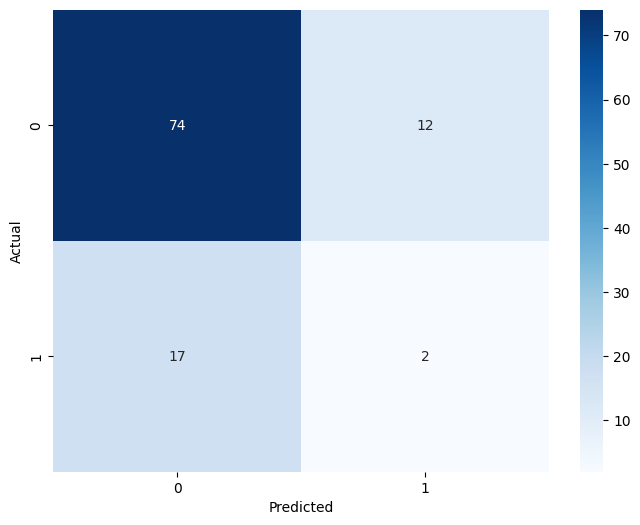

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix using the pd.crosstab() function
confusion_matrix = pd.crosstab(df['label'], df['BERT_Preds'], rownames=['Actual'], colnames=['Predicted'])

# Set the size of the plot
plt.figure(figsize=(8, 6))

# Create a heatmap with the seaborn library
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g')

# Add labels for the x and y axes
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()


# Part B)
#Q1) Does your model learn features of the phenomenon that you didn't consider in your guidelines that might cause you to rethink the category boundaries?

A) No, the BERT model in question is capable of making predictions based on an analysis of the words in each email (while taking into account their context), and that was something that was very well within the breadth of our guidelines. However, this model falls short (when it comes to following our guidelines) in that it is not aware of the historical context of the enron scandal, and is does not have a contextual understanding of who is sending the email, and why certain correspondences from these people may be important in discerning criminality or non-criminality. 

#Q2) What labels are often mistaken for each other?
1s are often mistaken for 0s by the BERT Model according to our confusion matrix


#Q3) What features are learned to most define the classes?

the model learned to pay attention to certain keywords, phrases, or patterns that are particularly indicative of the criminal behavior, such as references to illegal activities, bribes, or incriminating conversations.

# Q4) What kind of systematic mistakes does your model make? This could involve reading through test predictions and manually categorizing mistakes that are made

The BERT Model seems to read overly into words that are seemingly negative like the word "forbidden" as displayed in the text in row 95 of the test set. In essence, the model relies on words that seem to precede malintent, or contexts that seem to describe whether or not something is allowed. The mistakes come into play, when we realize that not every dialogue about something being "not allowed" always coincides with criminal actions or behaviours. sometimes, as is common in these emails, these phrases are stated in jest. 

# Q5) Are there any biases your model makes? (E.g., by performing worse on different dialects or registers of the language -- see Blodgett et al. 2016Links to an external site. for an example.)

The model seems to have a bias towards non-criminality largely because the vast majority of the emails sent within enron were mundane. 

# Q6) Think about the level of balance in your dataset: Is one label extremely prevalent? How could this impact the model you developed? Is your dataset a good candidate for strategies like oversampling or changing class weights? 

The dataset actually ended up being largely skewed towards more mundane (non-criminal emails) just because the bulk of the criminally relevant emails in the enron corpus came from a small subsection of the workforce, and, even then, a lot of these emails (among this subsection of the workforce) were more mundane and presented less criminal inclination than mundanity in the vast majority of cases. 

As such, our dataset is a perfect candidate for oversampling and/or changing class weights. the latter may be particularly helpful because by changing the class weights, the objective function of the model would be modified to reflect the imbalance in the data, and this might lead to better performance on the under-represented class -- ultimately resulting in better overall accuracy and model performance...exciting stuff!

